## Importowanie potrzebnych modułów

In [99]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models, datasets
from torchvision.utils import make_grid
from torch.utils.data import DataLoader

In [100]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import random
from math import log10, sqrt, ceil
from statistics import mean, stdev, median

import pandas as pd
import json

In [101]:
d=1
p=0.5
loops = 5

In [102]:
im_dir = '../wykresy/'

## Funkcje transferujące dane do dostępnego urządzenia

In [103]:
# ustawienie urządzenia

def get_default_device():
    if torch.cuda.is_available():
        print('gpu is active')
        return torch.device('cuda')
    else:
        print('cpu is active')
        return torch.device('cpu')

In [104]:
# funkcja transferująca tensory do wybranego urządzenia

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [105]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    def __len__(self):
        return len(self.dl)

In [106]:
device = get_default_device()

gpu is active


## Pobranie zbioru treningowego i testowego

In [107]:
transform = transforms.ToTensor()

In [108]:
train_data = datasets.CIFAR10('./', train=True, download=True, transform=transform)

test_data = datasets.CIFAR10('./', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [109]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

In [110]:
train_loader = DeviceDataLoader(train_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

## Funkcje treningowe sieci

In [111]:
def loss_batch(model, loss_func, xb, yb, opt=None, metric=None):
    preds = model(xb)
    loss = loss_func(preds, yb)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    metric_result = None
    if metric is not None:
        metric_result = metric(preds, yb)
    
    return loss.item(), len(xb), metric_result

def evaluate(model, loss_func, test_loader, metric=None):
    with torch.no_grad():
        results = [loss_batch(model, loss_func, xb, yb, metric=metric) for xb,yb in test_loader]
        losses, nums, metrics = zip(*results)
        
        total = np.sum(nums)
        
        avg_loss = np.sum(np.multiply(losses, nums)) / total
        
        avg_metric = None
        
        if metric is not None:
            avg_metric = np.sum(np.multiply(metrics, nums)) / total
        return avg_loss, total, avg_metric

import time

def fit(epochs, lr, model, loss_func, train_loader, test_loader, metric=None, opt_func=None):
    start = time.time()
    losses, metrics = [], []
    
    if opt_func is None:
        opt_func = torch.optim.Adam
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        for xb, yb in train_loader:
            loss,_,_ = loss_batch(model, loss_func, xb, yb, opt)
        result = evaluate(model, loss_func, test_loader, metric)
        val_loss, total, val_metric = result
        
        losses.append(val_loss)
        metrics.append(val_metric)
        
        if metric is None:
            print(f'Epoch: [{epoch+1}/{epochs}]\tLoss: {val_loss:.4f}\tElapsed time: {((time.time()-start)/60):.2f} minutes')
        else:
            print(f'Epoch: [{epoch+1}/{epochs}]\tLoss: {val_loss:.4f}\t{metric.__name__}: {val_metric:.4f}\tElapsed time: {((time.time()-start)/60):.2f} minutes')
    return losses, metrics

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.sum(preds == labels).item() / len(preds)

## Deklaracja sieci

In [112]:
if d==1:
    class CNN(nn.Module):
        def __init__(self, p=0.0):
            super().__init__()
            self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1)
            self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
            self.drop1 = nn.Dropout(0.25)
            self.conv3 = nn.Conv2d(32, 32, 3, 1, padding=1)
            self.conv4 = nn.Conv2d(32, 64, 3, 1, padding=1)
            self.drop2 = nn.Dropout(p)
            self.fc1 = nn.Linear(64*8*8,256)
            self.fc2 = nn.Linear(256,64)
            self.fc3 = nn.Linear(64,10)
        
        def forward(self, X):
            X = F.relu(self.conv1(X)) %(((32-2-2)/2)-2-2)/2
            X = F.relu(self.conv2(X))
            X = F.max_pool2d(X,2,2)
            X = F.relu(self.drop1(self.conv3(X)))
            X = F.relu(self.conv4(X))
            X = F.max_pool2d(X,2,2)
            X = X.view(-1, 8*8*64)
            X = F.relu(self.drop2(self.fc1(X)))
            X = F.relu(self.fc2(X))
            X = self.fc3(X)
        
            return F.log_softmax(X, dim=1)
        
elif d==2:   
    class CNN(nn.Module):
        def __init__(self, p=0.0):
            super().__init__()
            self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1)
            self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
            self.drop1 = nn.Dropout(0.25)
            self.conv3 = nn.Conv2d(32, 32, 3, 1, padding=1)
            self.conv4 = nn.Conv2d(32, 64, 3, 1, padding=1)
            self.fc1 = nn.Linear(64*8*8,256)
            self.drop2 = nn.Dropout(p)
            self.fc2 = nn.Linear(256,64)
            self.fc3 = nn.Linear(64,10)
        
        def forward(self, X):
            X = F.relu(self.conv1(X)) %(((32-2-2)/2)-2-2)/2
            X = F.relu(self.conv2(X))
            X = F.max_pool2d(X,2,2)
            X = F.relu(self.drop1(self.conv3(X)))
            X = F.relu(self.conv4(X))
            X = F.max_pool2d(X,2,2)
            X = X.view(-1, 8*8*64)
            X = F.relu(self.fc1(X))
            X = F.relu(self.drop2(self.fc2(X)))
            X = self.fc3(X)
        
            return F.log_softmax(X, dim=1)

In [113]:
model = CNN(p=p)

In [114]:
to_device(model, device)

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (drop1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (drop2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

## Trenowanie sieci i rysowanie wykresów

In [115]:
losses1, metrics1 = fit(10, 0.001, model, F.cross_entropy, train_loader, test_loader, accuracy)

Epoch: [1/10]	Loss: 1.5336	accuracy: 0.4486	Elapsed time: 0.78 minutes
Epoch: [2/10]	Loss: 1.2821	accuracy: 0.5351	Elapsed time: 1.55 minutes
Epoch: [3/10]	Loss: 1.1438	accuracy: 0.5892	Elapsed time: 2.35 minutes
Epoch: [4/10]	Loss: 1.0794	accuracy: 0.6172	Elapsed time: 3.13 minutes
Epoch: [5/10]	Loss: 1.0652	accuracy: 0.6306	Elapsed time: 3.90 minutes
Epoch: [6/10]	Loss: 0.9694	accuracy: 0.6632	Elapsed time: 4.67 minutes
Epoch: [7/10]	Loss: 0.9729	accuracy: 0.6591	Elapsed time: 5.43 minutes
Epoch: [8/10]	Loss: 0.9951	accuracy: 0.6552	Elapsed time: 6.20 minutes
Epoch: [9/10]	Loss: 0.9231	accuracy: 0.6803	Elapsed time: 6.96 minutes
Epoch: [10/10]	Loss: 0.9444	accuracy: 0.6751	Elapsed time: 7.72 minutes


In [116]:
torch.save(model.state_dict(), f'../model/d-{d}_p-{int(p*100)}.pt')

Text(0, 0.5, 'Skuteczność')

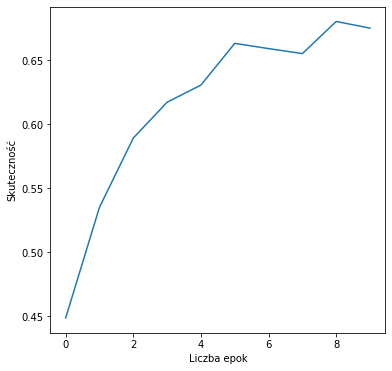

In [117]:
fig1 = plt.figure(figsize=(6, 6))
plt.plot(range(10), metrics1)
plt.xlabel('Liczba epok')
plt.ylabel('Skuteczność')

## Entropia
$H(x) = - \sum_{i=1}^{n} p(x_i) \log p(x_i)$

In [ ]:
def get_prediction(model, data, device, image_number, loops, print_pred=False):
    model.eval()
    for m in model.modules():
      if m.__class__.__name__.startswith('Dropout'):
        m.train()
        
    data_im = data[image_number][0]
    
    all_preds = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    
    for i in range(loops):
        with torch.no_grad():
            pred = model(to_device(data_im,device).view(1,3,32,32))
            pred = torch.exp(pred)
            pred = pred[0].tolist()

        all_preds = [all_preds[i]+pred[i] for i in range(len(pred))]
        pred = [f'{el:.4f}' for el in pred]
        if print_pred:
            print(f'{i}.\t{pred}\tAVG:\t{avg_pred:.4f}')
        
    avg_list = [el/loops for el in all_preds]
    
    return avg_list

**Funkcja statystyczna, w której wywyołana jest funckja entropii, liczona jest średnia i odchylenie standardowe z podanej liczby _loops_**

In [ ]:
def entropy(model, test_data, device, loops, image_number=random.randint(0,9999), print_entropy=False, print_pred=False):

    avg_list = get_prediction(model, test_data, device, image_number, loops, print_pred)
    
    elem = [el*log10(el) for el in avg_list]
    H = np.sum(elem)
    H = -H
    
    if print_entropy:
        print(H)
        
    return H, avg_list

In [ ]:
# konwencja nazewnicza

naming = f'loops-{loops}_d-{d}_'

## Rysowanie wykresów pudełkowych

### Zbiór treningowy

In [ ]:
if not os.path.isfile(f'{naming}.json'):
    with open(f'{naming}.json', "w+") as fileText:
        fileText.writelines('{}')

In [ ]:
with open(f'{naming}.json', mode='r') as fileJSON:
    dataJSON = json.load(fileJSON)

In [ ]:
if f'train-{int(p*100)}' not in dataJSON:
    st_time = time.time()

    train_data_entropy = {}
    train_data_length = len(train_data.data)

    for im in range(train_data_length):
        H, avg_list = entropy(model, train_data, device, loops, im, print_entropy=False, print_pred=False)
        sys.stdout.write(f'\rImage {im}')
        sys.stdout.flush()
        train_data_entropy[im] = H
        
    print('***************************************************')
    print(f'Elapsed time: {(time.time() - st_time)/60} minutes')

In [ ]:
if f'train-{int(p*100)}' not in dataJSON:
    train_data_params = {
        'all': train_data_entropy,
        'mean': mean(list(train_data_entropy.values())),
        'st_dev': stdev(list(train_data_entropy.values())),
        'length': train_data_length
    }
    
    dataJSON[f'train-{int(p*100)}'] = train_data_params
    
    with open(f'{naming}.json', mode='w') as fileJSON:
        fileJSON.write(json.dumps(dataJSON))

### Zbiór testowy

In [ ]:
if f'test-{int(p*100)}' not in dataJSON:
    st_time = time.time()

    test_data_entropy = {}
    test_data_length = len(test_data.data)

    for im in range(test_data_length):
        H, avg_list = entropy(model, test_data, device, loops, im, print_entropy=False, print_pred=False)
        sys.stdout.write(f'\rImage {im}')
        sys.stdout.flush()
        test_data_entropy[im] = H
        
    print('***************************************************')
    print(f'Elapsed time: {(time.time() - st_time)/60} minutes')

In [ ]:
if f'test-{int(p*100)}' not in dataJSON:
    test_data_params = {
        'all': test_data_entropy,
        'mean': mean(list(test_data_entropy.values())),
        'st_dev': stdev(list(test_data_entropy.values())),
        'length': test_data_length
    }
    
    dataJSON[f'test-{int(p*100)}'] = test_data_params
    
    with open(f'{naming}.json', mode='w') as fileJSON:
        fileJSON.write(json.dumps(dataJSON))

### Zbiór zewnętrzny

In [ ]:
outer_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor()
])

In [ ]:
outer_data = datasets.ImageFolder('./zbior_zewnetrzny/', transform=outer_transform)

In [ ]:
if f'outer-{int(p*100)}' not in dataJSON:
    st_time = time.time()

    outer_data_entropy = {}
    outer_data_length = len(outer_data)

    for im in range(outer_data_length):
        H, avg_list = entropy(model, outer_data, device, loops, im, print_entropy=False, print_pred=False)
        sys.stdout.write(f'\rImage {im}')
        sys.stdout.flush()
        outer_data_entropy[im] = H
        
    print('***************************************************')
    print(f'Elapsed time: {(time.time() - st_time)/60} minutes')

In [ ]:
if f'outer-{int(p*100)}' not in dataJSON:
    outer_data_params = {
        'all': outer_data_entropy,
        'mean': mean(list(outer_data_entropy.values())),
        'st_dev': stdev(list(outer_data_entropy.values())),
        'length': outer_data_length
    }
    
    dataJSON[f'outer-{int(p*100)}'] = outer_data_params
    
    with open(f'{naming}.json', mode='w') as fileJSON:
        fileJSON.write(json.dumps(dataJSON))

In [ ]:
train_val = list(dataJSON[f'train-{int(p*100)}']['all'].values())
test_val = list(dataJSON[f'test-{int(p*100)}']['all'].values())
outer_val = list(dataJSON[f'outer-{int(p*100)}']['all'].values())

In [ ]:
fig = plt.figure(figsize=(20, 6))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
box_train = ax1.boxplot(train_val, sym="b.")
ax1.set_title('Zbiór treningowy')
box_test = ax2.boxplot(test_val, sym="b.")
ax2.set_title('Zbiór testowy')
box_outer = ax3.boxplot(outer_val, sym="b.")
ax3.set_title('Zbiór zewnętrzny')
ax1.set_ylim(ymin=-0.05, ymax=1.05)
ax2.set_ylim(ymin=-0.05, ymax=1.05)
ax3.set_ylim(ymin=-0.05, ymax=1.05)
plt.setp(plt.gcf().get_axes(), xticks=[])

# plt.savefig(fname=f'{im_dir}loops-{loops}/d-{d}/p-{int(p*100)}')

In [ ]:
if p == 0.5:
    means = {
        'train': [],
        'test': [],
        'outer': []
    }

    for i in range(1, 6):
        with open(f'{naming}.json', mode='r') as file:
            fjson = json.load(file);
            means['train'].append(fjson[f'train-{int(i*10)}']['mean'])
            means['test'].append(fjson[f'test-{int(i*10)}']['mean'])
            means['outer'].append(fjson[f'outer-{int(i*10)}']['mean'])

    x = [0.1, 0.2, 0.3, 0.4, 0.5]
    
    fig1 = plt.figure(figsize=(6, 6))
    plt.plot(x, means['train'], marker='o', label='zbiór treningowy')
    plt.plot(x, means['test'], marker='o', label='zbiór testowy')
    plt.plot(x, means['outer'], marker='o', label='zbiór zewnętrzny')
    plt.xticks(np.arange(0.1, 0.6, 0.1))
    plt.xlabel('p')
    plt.ylabel('średnia entropia')
    plt.legend()
#     plt.savefig(fname=f'{im_dir}loops-{loops}/d-{d}/entropia')

In [ ]:
if p == 0.5:
    with open(f'{loops}_place-{d}_.json') as j1:
        j1p = json.load(j1)
    

    fig1, axs = plt.subplots(5, 3)
    for ax, col in zip(axs[0], ['zbiór treningowy', 'zbiór testowy', 'zbiór zewnętrzny']):
        ax.set_title(col)
        
    for ax, row in zip(axs[:,0], ['p=0.1', 'p=0.2', 'p=0.3', 'p=0.4', 'p=0.5']):
        ax.set_ylabel(row, rotation=90, size='medium')
        
    plt.rcParams["figure.figsize"] = (12,20)
    axs[0,0].boxplot(list(j1p[f'train-10']['all'].values()), sym="b.")
    axs[0,0].set_ylim(ymin=-0.05, ymax=1.05)
    axs[1,0].boxplot(list(j1p[f'train-20']['all'].values()), sym="b.")
    axs[1,0].set_ylim(ymin=-0.05, ymax=1.05)
    axs[2,0].boxplot(list(j1p[f'train-30']['all'].values()), sym="b.")
    axs[2,0].set_ylim(ymin=-0.05, ymax=1.05)
    axs[3,0].boxplot(list(j1p[f'train-40']['all'].values()), sym="b.")
    axs[3,0].set_ylim(ymin=-0.05, ymax=1.05)
    axs[4,0].boxplot(list(j1p[f'train-50']['all'].values()), sym="b.")
    axs[4,0].set_ylim(ymin=-0.05, ymax=1.05)
    
    ###################################################################

    axs[0,1].boxplot(list(j1p[f'test-10']['all'].values()), sym="b.")
    axs[0,1].set_ylim(ymin=-0.05, ymax=1.05)
    axs[1,1].boxplot(list(j1p[f'test-20']['all'].values()), sym="b.")
    axs[1,1].set_ylim(ymin=-0.05, ymax=1.05)
    axs[2,1].boxplot(list(j1p[f'test-30']['all'].values()), sym="b.")
    axs[2,1].set_ylim(ymin=-0.05, ymax=1.05)
    axs[3,1].boxplot(list(j1p[f'test-40']['all'].values()), sym="b.")
    axs[3,1].set_ylim(ymin=-0.05, ymax=1.05)
    axs[4,1].boxplot(list(j1p[f'test-50']['all'].values()), sym="b.")
    axs[4,1].set_ylim(ymin=-0.05, ymax=1.05)

    ###################################################################
    
    axs[0,2].boxplot(list(j1p[f'outer-10']['all'].values()), sym="b.")
    axs[0,2].set_ylim(ymin=-0.05, ymax=1.05)
    axs[1,2].boxplot(list(j1p[f'outer-20']['all'].values()), sym="b.")
    axs[1,2].set_ylim(ymin=-0.05, ymax=1.05)
    axs[2,2].boxplot(list(j1p[f'outer-30']['all'].values()), sym="b.")
    axs[2,2].set_ylim(ymin=-0.05, ymax=1.05)
    axs[3,2].boxplot(list(j1p[f'outer-40']['all'].values()), sym="b.")
    axs[3,2].set_ylim(ymin=-0.05, ymax=1.05)
    axs[4,2].boxplot(list(j1p[f'outer-50']['all'].values()), sym="b.")
    axs[4,2].set_ylim(ymin=-0.05, ymax=1.05)
    plt.setp(plt.gcf().get_axes(), xticks=[])

#     plt.savefig(fname=f'{im_dir}loops-{loops}/d-{d}/wykresy-pudelkowe')